# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [3]:
df_offers.shape

(32, 7)

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\Zach Nguyen\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [5]:
df_transactions.shape

(324, 3)

In [6]:
len(df_transactions.customer_name.unique())

100

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

<div class="span5 alert alert-success">
<h3> Response </h3>
</div>

In [7]:
# Merge and Check the shape of the dataframe

df_merged = df_transactions.merge(df_offers, on = 'offer_id', how = 'outer')
df = df_merged[['customer_name', 'offer_id', 'n']]
df.shape

(324, 3)

In [8]:
# Create the pivot table to have customer name as row and campaign id as column

pivot = pd.pivot_table(df, values = 'n', index = 'customer_name', columns = 'offer_id', aggfunc= 'count', fill_value = 0)

In [9]:
# Check to make sure the shape of the pivot table (100 customers vs 32 campaigns)

pivot.shape

(100, 32)

In [10]:
# Reset index to bring customer name as a column

pivot = pivot.reset_index()

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pivot)

offer_id customer_name  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  \
0                Adams  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   
1                Allen  0  0  0  0  0  0  0  0  1   0   0   0   0   0   0   0   
2             Anderson  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   
3               Bailey  0  0  0  0  0  0  1  0  0   0   0   0   0   0   0   0   
4                Baker  0  0  0  0  0  0  1  0  0   1   0   0   0   0   0   0   
5               Barnes  0  0  0  0  0  0  0  0  0   1   0   0   0   0   0   0   
6                 Bell  0  1  0  0  0  0  0  0  0   0   0   0   0   0   0   0   
7              Bennett  0  0  0  0  0  0  0  1  0   0   0   0   0   0   0   0   
8               Brooks  0  0  1  0  0  0  0  1  0   0   1   0   0   0   0   0   
9                Brown  0  0  0  0  0  0  1  0  0   0   0   0   0   0   0   0   
10              Butler  1  0  0  1  0  0  0  0  0   0   0   0   0   0   0   0   
11            Campbell  0  1

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

<div class="span5 alert alert-success">
<h3> Response </h3>
Lower values of SS represent better clustering because it means the points in each cluster is more closely packed.
</div>


In [12]:
# Take the data without the customer names

x_cols = pivot.columns[1:]
x_cols

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name='offer_id')

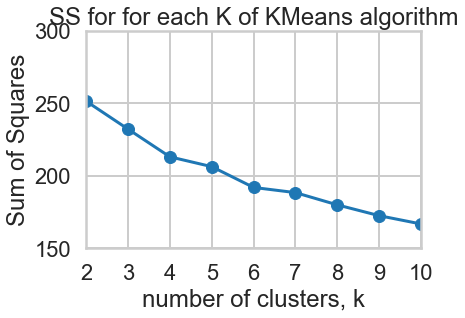

In [13]:
# Plot inertia plot

from sklearn.cluster import KMeans

ks = range(2, 11)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters= k)
    
    # Fit model to samples
    model.fit(pivot[x_cols])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.xticks(ks)
plt.xlim([2,10])
plt.ylabel('Sum of Squares')
plt.ylim(150,300)
plt.title('SS for for each K of KMeans algorithm')
plt.show()

<div class="span5 alert alert-success">
Although the cutoff is not very clear, I would choose k = 7 clusters.
</div>

In [14]:
# Assign clusters with the best cluster number (7) using the Elbow method

cluster = 7
model = KMeans(n_clusters= cluster)
pivot['cluster'] = model.fit_predict(pivot[x_cols])

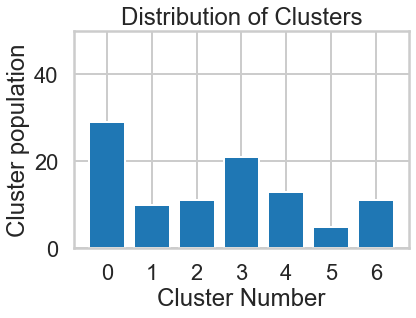

In [15]:
# Plot distribution of clusters

plt.bar(pivot.cluster.value_counts().index, pivot.cluster.value_counts())
plt.xticks(range(cluster))
plt.xlabel('Cluster Number')
plt.ylim(0,50)
plt.ylabel('Cluster population')
plt.title('Distribution of Clusters')
plt.show()

<div class="span5 alert alert-success">
In this case, it's really difficult to use the Elbow method to pick K since the curve looks more straight than Elbow shaped.
</div>



### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

<div class="span5 alert alert-success">
<h3> Response </h3>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09365573283492713
For n_clusters = 3 The average silhouette_score is : 0.11889942863638556
For n_clusters = 4 The average silhouette_score is : 0.12347053919571699
For n_clusters = 5 The average silhouette_score is : 0.14092516241984757
For n_clusters = 6 The average silhouette_score is : 0.1371798939109807
For n_clusters = 7 The average silhouette_score is : 0.1161092456616906
For n_clusters = 8 The average silhouette_score is : 0.11339573832632867
For n_clusters = 9 The average silhouette_score is : 0.12505960527779877
For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


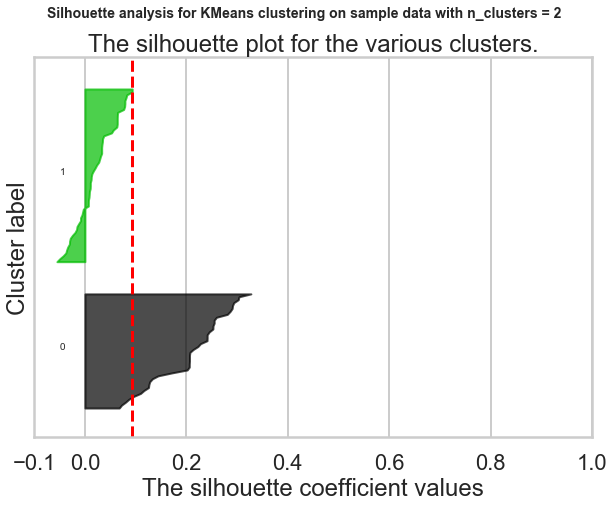

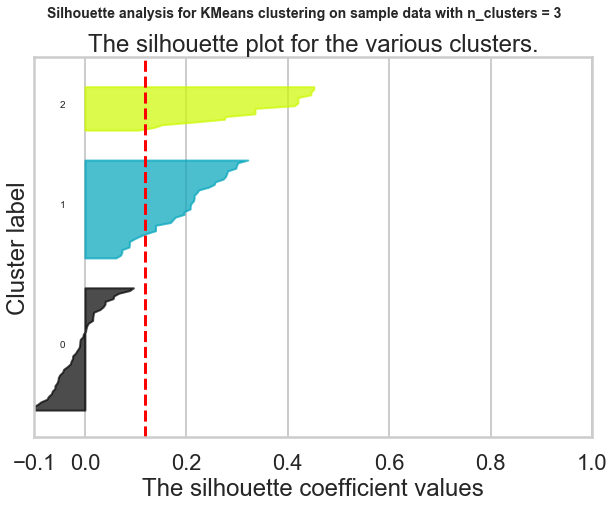

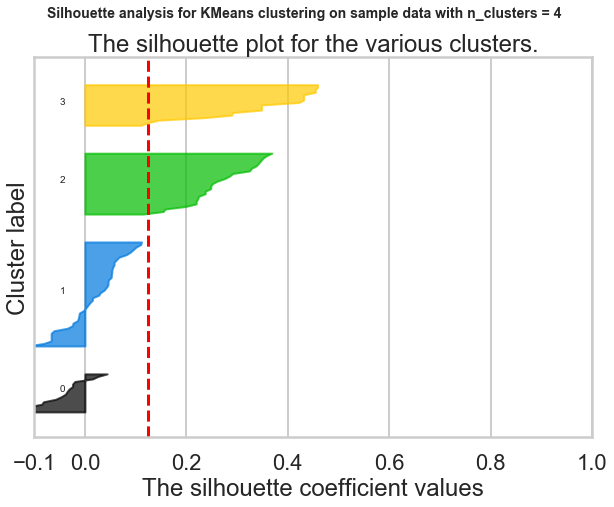

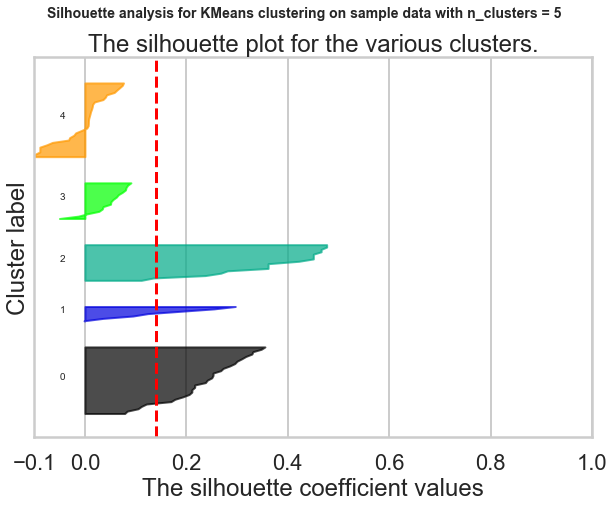

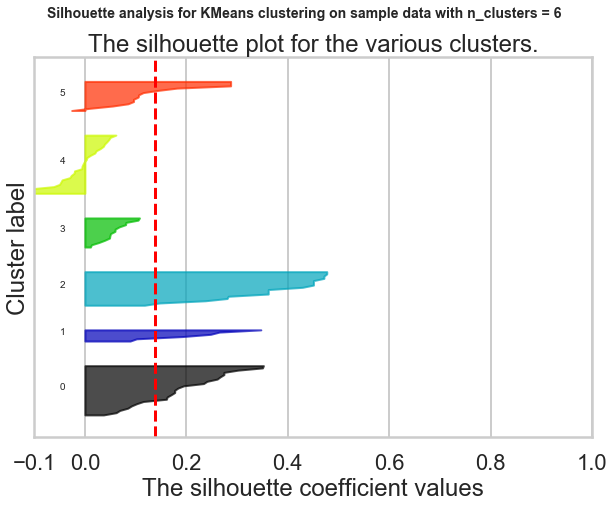

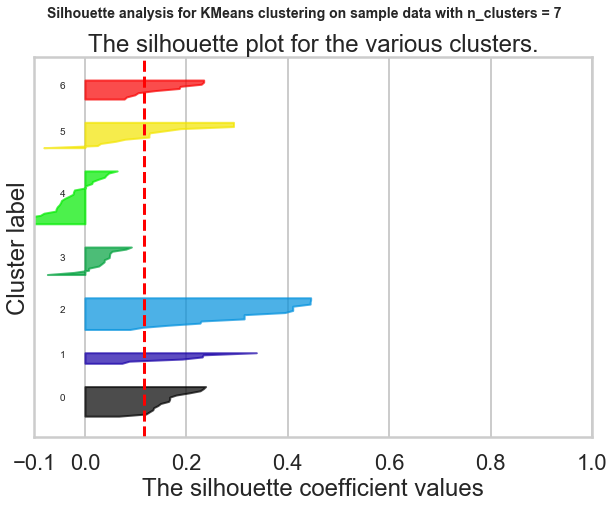

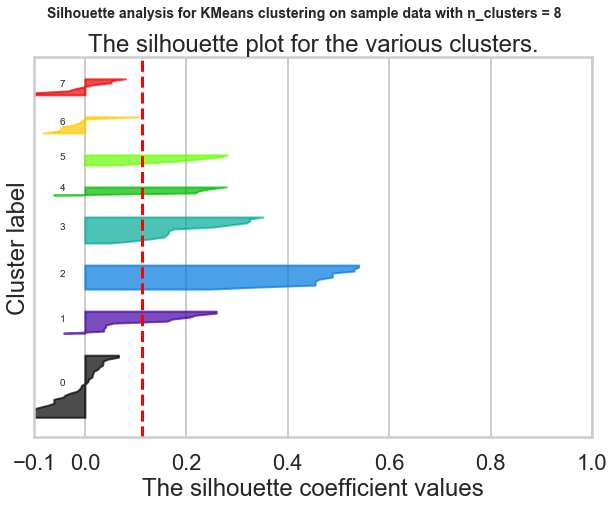

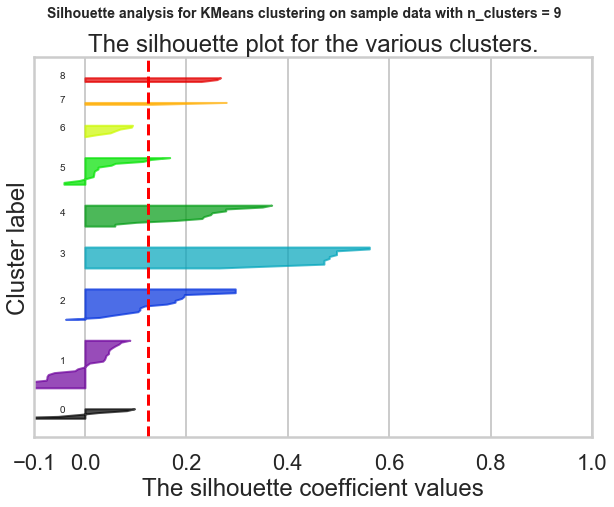

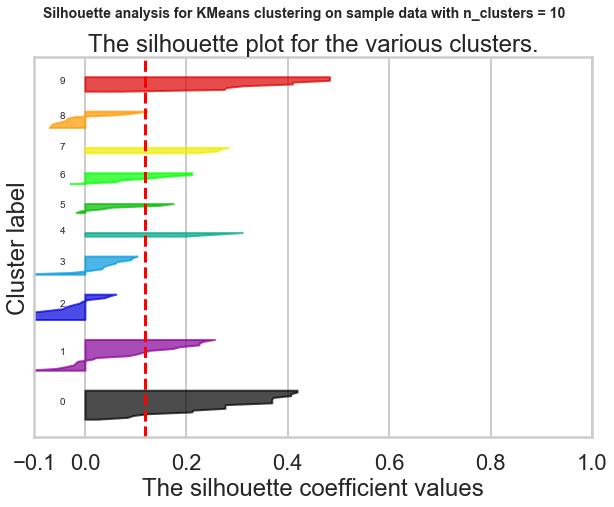

In [16]:
# Make sihouette plots

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

X = pivot[x_cols]

range_n_clusters = range(2,11)
silhouette_avgscores = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avgscores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Text(0.5, 1.0, 'Average Silhouette Scores for KMeans clustering')

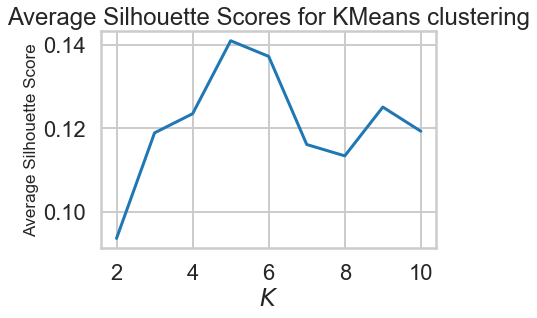

In [17]:
# Plot the Silhouette score for k = 2-10 clusters

plt.plot(range_n_clusters,silhouette_avgscores)
plt.xlabel('$K$')
plt.ylabel('Average Silhouette Score', size = 17)
plt.title('Average Silhouette Scores for KMeans clustering')

<div class="span5 alert alert-success">
The Sihoulette score close to +1 indicates that the average distance from one point to another within a cluster is almost 0 (this means a good score because we would have dense clusters).Based on the Sihoulette score, K = 5 seems to be the best cluster number. However, its score is only a little over 0.14 (less than 0.25). This means there is likely no substantial structure in the dataset given the number of clusters we limited ourselves to. Therefore, we should increase the test range.
</div>

In [18]:
# Find the silhouette score for k = 2 to 90

range_n_clusters = range(2,90)
silhouette_avgscores= []

for n_clusters in range_n_clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avgscores.append(silhouette_avg)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)

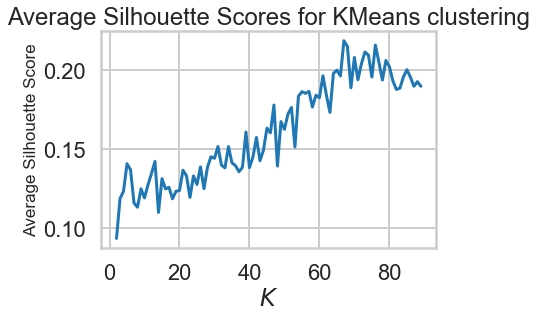

In [19]:
# Plot the scores for 2-90 clusters

plt.plot(range(2,90),silhouette_avgscores)
plt.xlabel('$K$')
plt.ylabel('Average Silhouette Score', size = 17)
plt.title('Average Silhouette Scores for KMeans clustering')
plt.show()

<div class="span5 alert alert-success">
We can see that the Silhouette score peaks at around k = 70
</div>

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

<div class="span5 alert alert-success">
<h3> Response </h3>
Since we visualizing 70 clusters is not possible, we can try to visualize all the clusters k = 2 to 5
</div>

In [20]:
# Run PCA to extract two pca components
from sklearn.decomposition import PCA

model = PCA(n_components = 2)
pca_features = model.fit_transform(X)
xs = pca_features[:,0]
ys = pca_features[:,1]


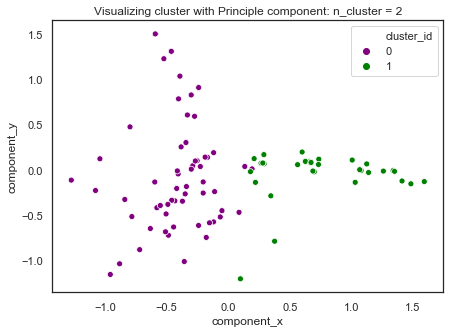

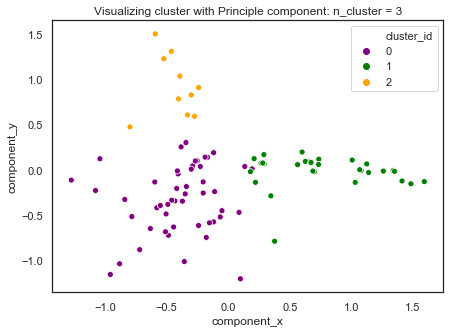

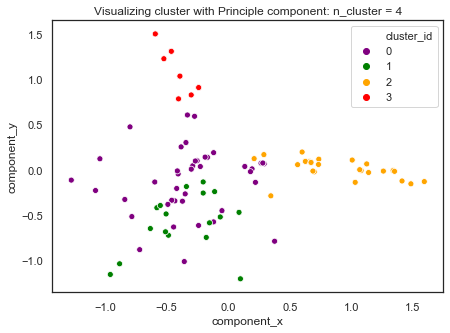

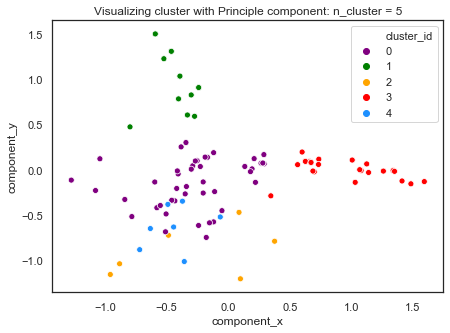

In [21]:
from sklearn.cluster import KMeans
clusters = range(2,6)
# Define a color dictionary for the plots
color_dict = dict({0:'purple',
                  1:'green',
                  2: 'orange',
                  3: 'red',
                   4: 'dodgerblue',
                  5: 'yellow',
                  6: 'black'})
sns.set(style='white')
df_list = []
for cluster in clusters:
    # Run KMeans on the data with 5 clusters
    model = KMeans(n_clusters = cluster)
    cluster_id = model.fit_predict(X)
    
    # Create a dataframe with customer name, cluster id, component x and component y
    df = pd.DataFrame({'customer_name': pivot['customer_name'], 
                       'cluster_id': cluster_id, 
                       'component_x':xs, 
                       'component_y':ys})
    df_list.append(df)
    # Plot the color-coded scatter plots
    sns.set(style='white')
    plt.figure(figsize=(7,5))
    sns.scatterplot( x = 'component_x', y = 'component_y', hue = 'cluster_id', 
                palette=color_dict, data = df)
    plt.title('Visualizing cluster with Principle component: n_cluster = %i' % cluster)
    plt.show()

<div class="span5 alert alert-success">
Visually, we can see that K = 3 makes the most distinct clusters
</div>

In [22]:
# Take the dataframe with 3 clusters

df = df_list[1]

<div class="span5 alert alert-success">
Exploratory Data Analysis
</div>


In [23]:
df.head()

,customer_name,cluster_id,component_x,component_y
0,Adams,1,1.007580,0.108215
1,Allen,0,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,1,0.699477,-0.022542
4,Baker,0,0.088183,-0.471695


In [24]:
# Define our customer segmentation based on the generated clusters

customer_seg = {}
for cluster in range(3):
    customer_seg[cluster] = df[df.cluster_id == cluster].customer_name.unique()
customer_seg

{0: array(['Allen', 'Baker', 'Barnes', 'Brooks', 'Butler', 'Clark', 'Collins',
        'Cooper', 'Davis', 'Evans', 'Fisher', 'Foster', 'Garcia', 'Gomez',
        'Gonzalez', 'Hall', 'Harris', 'Howard', 'Jackson', 'Kelly', 'Lee',
        'Lopez', 'Martin', 'Martinez', 'Miller', 'Mitchell', 'Morales',
        'Nelson', 'Nguyen', 'Parker', 'Powell', 'Price', 'Ramirez', 'Reed',
        'Reyes', 'Richardson', 'Roberts', 'Sanchez', 'Sanders', 'Scott',
        'Thomas', 'Thompson', 'Turner', 'Ward', 'White', 'Williams',
        'Wood', 'Wright', 'Young'], dtype=object),
 1: array(['Adams', 'Bailey', 'Bennett', 'Brown', 'Carter', 'Cruz', 'Diaz',
        'Edwards', 'Green', 'Gutierrez', 'Hernandez', 'Hill', 'Hughes',
        'James', 'Jones', 'King', 'Lewis', 'Long', 'Morgan', 'Murphy',
        'Myers', 'Ortiz', 'Perez', 'Perry', 'Rivera', 'Robinson', 'Rogers',
        'Ross', 'Stewart', 'Sullivan', 'Taylor', 'Torres', 'Walker',
        'Watson', 'Wilson'], dtype=object),
 2: array(['Anderson',

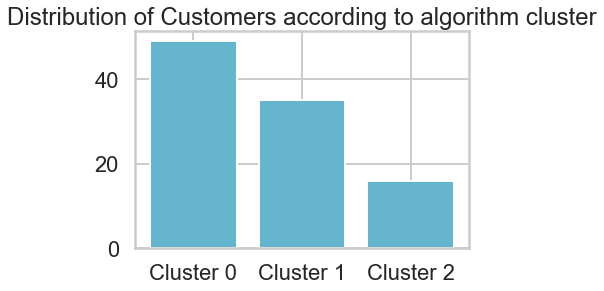

In [25]:
# Visualize the distribution of Customers in each cluster

sns.set_style("whitegrid")
sns.set_context("poster")
plt.bar(x = ['Cluster 0', 'Cluster 1', 'Cluster 2'],
       height = [len(customer_seg[0]), len(customer_seg[1]), len(customer_seg[2])],
       color = 'c')
plt.title('Distribution of Customers according to algorithm cluster')
plt.show()

<div class="span5 alert alert-success">
The distribution of customers to the three cluster was uneven. Cluster 0 has the most customers and cluster 2 has less than half of cluster 0.
</div>


In [26]:
# Merge the dataframe on the new cluster information

df_merged = df_merged.merge(df, on = 'customer_name')
df_merged.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,cluster_id,component_x,component_y
0,Smith,2,1,January,Pinot Noir,72,17,France,False,2,-0.300227,0.829765
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False,2,-0.300227,0.829765
2,Rodriguez,2,1,January,Pinot Noir,72,17,France,False,2,-0.403273,0.786296
3,Rodriguez,26,1,October,Pinot Noir,144,83,Australia,False,2,-0.403273,0.786296
4,Martin,2,1,January,Pinot Noir,72,17,France,False,0,-0.382241,0.254034


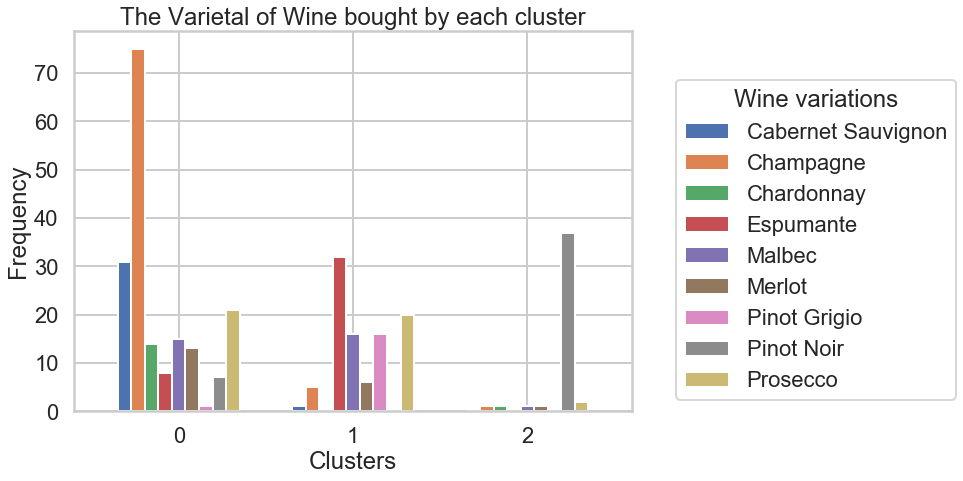

In [27]:
# Crosstab and plot the wine preference of each customer segment

pd.crosstab(df_merged.cluster_id, df_merged.varietal).plot(kind='bar', width = 0.7, figsize=(10,7))
plt.xlabel('Clusters')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(title = 'Wine variations',loc="upper right", bbox_to_anchor=(1.6, 0.9))
plt.title('The Varietal of Wine bought by each cluster')
plt.show()

<div class="span5 alert alert-success">
Cluster 2 really stood out, since most of the purchase in this cluster is the "Pinot Noir" product. Cluster 0 and 1 favors different types of wine (Cluster 0 seems to like "Champagne", "Cabernet Sauvignon", "Chardonnay" and "Merlot" whereas Cluster 1 like "Espunmante", "Pinot Grigio" and "Prosecco"). However, "Malbec" seems to be the wine type that customers in both cluster enjoy.
</div>


In [28]:
# Explore customer segment seasonality habits. 
# Convert campaign time into numerical representation of date 

month_dict = {'January':1,
         'February':2, 
         'March':3, 
         'April':4, 
         'May': 5,
         'June': 6, 
         'July': 7,
         'August': 8, 
         'September': 9, 
         'October': 10, 
         'November': 11, 
         'December': 12}
df_merged['month'] = df_merged['campaign'].map(month_dict)
df_merged.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,cluster_id,component_x,component_y,month
0,Smith,2,1,January,Pinot Noir,72,17,France,False,2,-0.300227,0.829765,1
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False,2,-0.300227,0.829765,9
2,Rodriguez,2,1,January,Pinot Noir,72,17,France,False,2,-0.403273,0.786296,1
3,Rodriguez,26,1,October,Pinot Noir,144,83,Australia,False,2,-0.403273,0.786296,10
4,Martin,2,1,January,Pinot Noir,72,17,France,False,0,-0.382241,0.254034,1


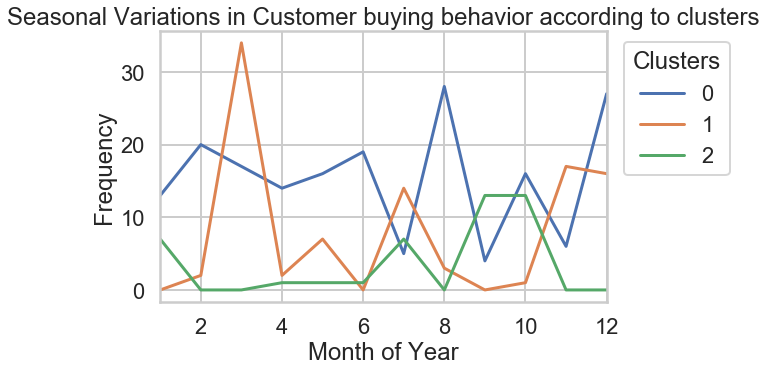

In [29]:
# Plot each cluster's seasonality habits

pd.crosstab(df_merged.cluster_id, df_merged.month).transpose().plot(kind='line', figsize=(8,5))
plt.xlabel('Month of Year')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.legend(title = 'Clusters', loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title('Seasonal Variations in Customer buying behavior according to clusters')
plt.show()

<div class="span5 alert alert-success">
Cluster 0 has relatively stable buying habits with some fluctuations.
Cluster 1 has peak response to promotion during March. We could investigate if this is by chance or there is a legitimate reason (certain festivals, celebrations, types of wine fits the ambient temperature ...etc).
Cluster 2 is more active in the fall months. 
Perhaps we need more data to see a smoother curve and distinguish any pattern. Also, we will need the distribution of each month's impressions to actually grasp the true frequency of response to advertisement in each cluster. 
</div>

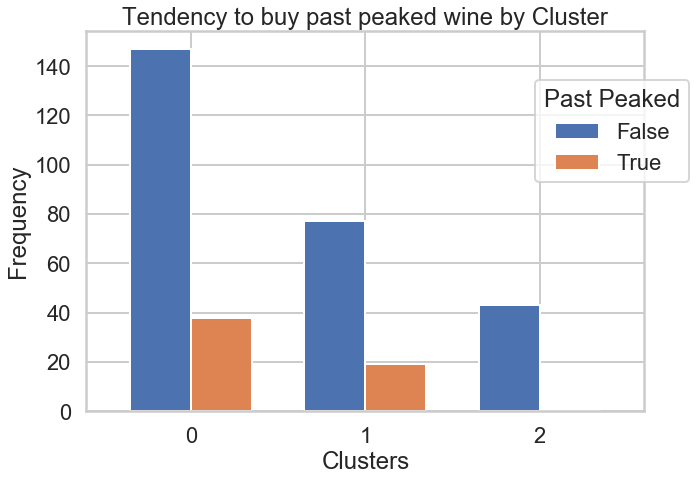

In [30]:
# Explore each cluster's taste for freshness

pd.crosstab(df_merged.cluster_id, df_merged.past_peak).plot(kind='bar', width = 0.7, figsize=(10,7))
plt.xlabel('Clusters')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(title = 'Past Peaked',loc="upper right", bbox_to_anchor=(1.1, 0.9))
plt.title('Tendency to buy past peaked wine by Cluster')
plt.show()

<div class="span5 alert alert-success">
It seems most customers enjoy freshwine more, especially cluster 2. However, there is no clearly distinguishing features for cluster 0 and cluster 1 with this variable. 
</div>

<div class="span5 alert alert-success">
    <b>Conclusion:</b> Champagne is the company's most popular discounted product and a particular group of custer (cluster 0) is particular sensitive to it in March. It is recommended that the company look deeper into the demographic/socio-economic class of cluster 0 to figure out the best way to deliver promotion to them effectively. A regular group of customers (cluster 2) regularly respond in the fall months (September, October) to promotion for Pinot Noir, so the company should focus its Pinot Noir promotions on those months to save costs.  
</div>

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

<div class="span5 alert alert-success">
<h3> Response </h3>
</div>

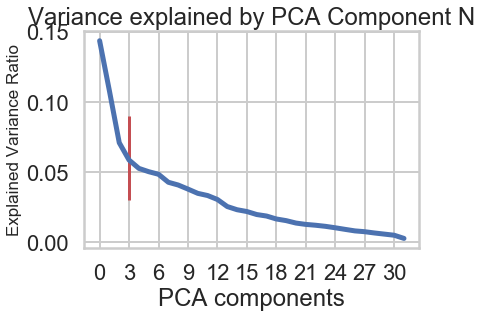

In [31]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Plot the explained variance according to number of components
plt.plot(pca.explained_variance_ratio_,color='b',linewidth=5)
plt.xticks(np.arange(0,31,3))
plt.vlines(3,  ymin = 0.03, ymax = 0.09, color = 'r')
plt.xlabel('PCA components')
plt.ylabel('Explained Variance Ratio', size = 17)
plt.title('Variance explained by PCA Component N')
plt.show()

<div class="span5 alert alert-success">
Eye-balling the curve, we could see that the Elbow is at 3 PCA components. Component number 3 was able to explain much more than component 4, 5 and so on .. Thus, 3 is likely the optimal dimension for the dataset.
</div>

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


<div class="span5 alert alert-success">
<h3> Response </h3>
</div>

In [32]:
# Initalize a dictionary to record the performances

model_perf = dict.fromkeys(['Affinity Propagation', 'Spectral Clustering', 
                            'Agglomerative Clustering', 'DBSCAN'])

<div class="span5 alert alert-success">
Affinity Propagation
</div>

In [33]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [34]:
model = AffinityPropagation().fit(X)
n_clusters = len(model.cluster_centers_indices_)
labels = model.labels_
print('Total estimated clusters using Affinity Propogation: %i' % n_clusters)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Total estimated clusters using Affinity Propogation: 14
Silhouette Coefficient: 0.180


In [35]:
model_perf['Affinity Propagation'] = metrics.silhouette_score(X, labels, metric='sqeuclidean')

<div class="span5 alert alert-success">
Spectral Clustering
</div>

In [36]:
from sklearn.cluster import SpectralClustering

In [37]:
scores = [0,0]
for cluster in range(2, 50):
    model = SpectralClustering(n_clusters=cluster).fit(X)
    scores.append(metrics.silhouette_score(X, model.labels_, metric='sqeuclidean')) 

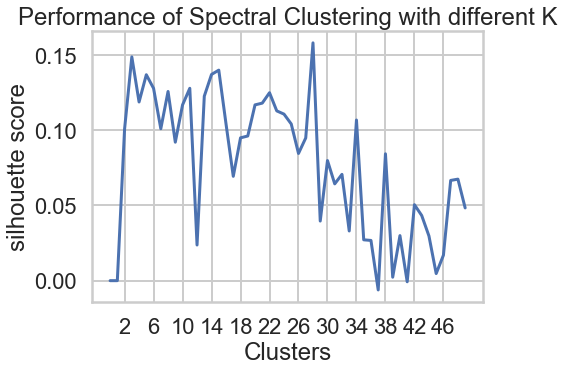

In [38]:
plt.figure(figsize=(7,5))
plt.plot(scores)
plt.xticks(range(2,50,4))
plt.xlabel('Clusters')
plt.ylabel('silhouette score')
plt.title('Performance of Spectral Clustering with different K')
plt.show()

In [39]:
model = SpectralClustering(n_clusters = 19).fit(X)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, model.labels_, metric='sqeuclidean'))

Silhouette Coefficient: 0.113


In [40]:
model_perf['Spectral Clustering'] = metrics.silhouette_score(X, model.labels_, metric='sqeuclidean')

<div class="span5 alert alert-success">
Agglomerative Clustering
</div>

In [41]:
from sklearn.cluster import AgglomerativeClustering

In [42]:
scores = [0,0]
for cluster in range(2, 50):
    model = AgglomerativeClustering(n_clusters=cluster, linkage='complete').fit(X)
    scores.append(metrics.silhouette_score(X, model.labels_, metric='sqeuclidean')) 

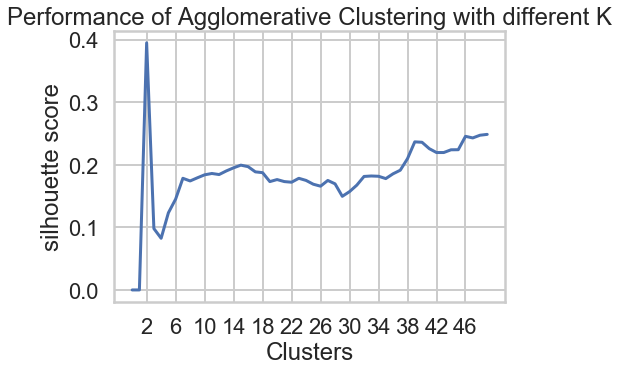

In [43]:
plt.figure(figsize=(7,5))
plt.plot(scores)
plt.xticks(range(2,50,4))
plt.xlabel('Clusters')
plt.ylabel('silhouette score')
plt.title('Performance of Agglomerative Clustering with different K')
plt.show()

In [44]:
model = AgglomerativeClustering(n_clusters=2, linkage='complete').fit(X)
scores.append(metrics.silhouette_score(X, model.labels_, metric='sqeuclidean')) 
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, model.labels_, metric='sqeuclidean'))

Silhouette Coefficient: 0.395


In [45]:
model_perf['Agglomerative Clustering'] = metrics.silhouette_score(X, model.labels_, metric='sqeuclidean')

<div class="span5 alert alert-success">
DBSCAN
</div>

In [46]:
from sklearn.cluster import DBSCAN

In [47]:
scores = [0]
for neigh_size in range(1, 4):
    model = DBSCAN(min_samples = neigh_size)
    labels = model.fit_predict(X)
    scores.append(metrics.silhouette_score(X, labels, metric='sqeuclidean')) 

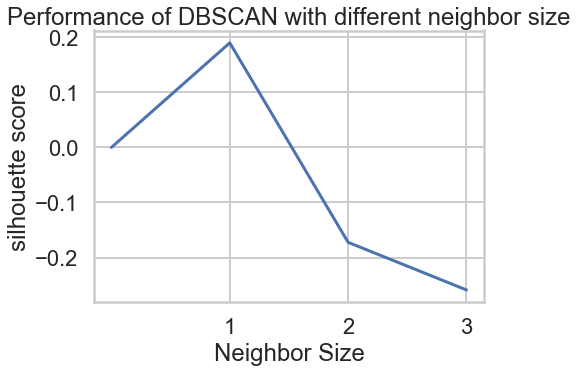

In [48]:
plt.figure(figsize=(7,5))
plt.plot(scores)
plt.xticks(range(1,4))
plt.xlabel('Neighbor Size')
plt.ylabel('silhouette score')
plt.title('Performance of DBSCAN with different neighbor size')
plt.show()

In [49]:
model = DBSCAN(min_samples = 1).fit(X)
labels = model.fit_predict(X)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Silhouette Coefficient: 0.190


In [50]:
model_perf['DBSCAN'] = metrics.silhouette_score(X, labels, metric='sqeuclidean')

In [51]:
model_perf

{'Affinity Propagation': 0.17978337664151187,
 'Spectral Clustering': 0.11292883996798739,
 'Agglomerative Clustering': 0.3949188869302381,
 'DBSCAN': 0.19}

In [52]:
pd.DataFrame.from_dict(model_perf, orient='index',
                      columns=['Silhouette Score'])

,Silhouette Score
Affinity Propagation,0.179783
Spectral Clustering,0.112929
Agglomerative Clustering,0.394919
DBSCAN,0.190000


<div class="span5 alert alert-success">
The clustering algorithm has wildly different results, but none of them really has significant structure but the Agglomerative Clustering. The Agglomerative Clustering algorithm has a very high silhouette score but only took 2 clusters. Thus, something might have gone wrong.
</div>